In [1]:
from pip._internal import main
main(["install","progressbar"])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


0

In [2]:
import progressbar
import time
import os
import struct
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import numpy as np
import librosa # for sound processing.
import DataCollection as dc # a local module

In [3]:
data = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:

data.shape[0]

8732

In [5]:

###data = data.sort_values(by=['fold', 'classID',"fsID"], ascending=[True, True, True])
dataset = np.zeros(shape = (data.shape[0],2),dtype = object)
dataset.shape

(8732, 2)

In [6]:
bar = progressbar.ProgressBar(maxval=data.shape[0], widgets=[progressbar.Bar('$', '||', '||'), ' ', progressbar.Percentage()])
bar.start()
for i in range(data.shape[0]):
    
    fullpath, class_id = dc.path_class(data,data.slice_file_name[i])
    try:
        X, sample_rate = librosa.load(fullpath, res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    except Exception:
        print("Error encountered while parsing file: ", file)
        mfccs,class_id = None, None
    feature = mfccs
    label = class_id
    dataset[i,0],dataset[i,1] = feature,label
    
    bar.update(i+1)

C:\Users\min\anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
C:\Users\min\anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
C:\Users\min\anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


In [7]:
np.save("dataset_melspectrogram",dataset,allow_pickle=True)

In [8]:
l = np.load("dataset_melspectrogram.npy")

In [9]:
l.shape

(8732, 2)

In [10]:
l[8730,1]

'car_horn'

model

In [11]:
import numpy as np
import pandas as pd

data = pd.DataFrame(np.load("dataset.npy",allow_pickle= True))
data.columns = ['feature', 'label']

from sklearn.preprocessing import LabelEncoder

X = np.array(data.feature.tolist())
y = np.array(data.label.tolist())
from sklearn.model_selection import train_test_split
X,val_x,y,val_y = train_test_split(X,y)
lb = LabelEncoder()

from keras.utils import np_utils

y = np_utils.to_categorical(lb.fit_transform(y))
val_y = np_utils.to_categorical(lb.fit_transform(val_y))

In [12]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 



num_labels = y.shape[1]
filter_size = 3



# build model
model = Sequential()


model.add(Dense(512, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Dense(num_labels))
model.add(Activation('softmax'))



model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               20992     
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2

In [14]:
model.fit(X, y, batch_size=64, epochs=20, validation_data=(val_x, val_y))

Epoch 1/20
103/103 [==============================] - 2s 18ms/step - loss: 6.8122 - accuracy: 0.1771 - val_loss: 2.1546 - val_accuracy: 0.2226
Epoch 2/20
103/103 [==============================] - 1s 14ms/step - loss: 2.2048 - accuracy: 0.2379 - val_loss: 2.0134 - val_accuracy: 0.3083
Epoch 3/20
103/103 [==============================] - 2s 16ms/step - loss: 2.0533 - accuracy: 0.2654 - val_loss: 1.8372 - val_accuracy: 0.3623
Epoch 4/20
103/103 [==============================] - 1s 12ms/step - loss: 1.9410 - accuracy: 0.3040 - val_loss: 1.7216 - val_accuracy: 0.4269
Epoch 5/20
103/103 [==============================] - 1s 12ms/step - loss: 1.8568 - accuracy: 0.3350 - val_loss: 1.6183 - val_accuracy: 0.4402
Epoch 6/20
103/103 [==============================] - 1s 8ms/step - loss: 1.7727 - accuracy: 0.3663 - val_loss: 1.5112 - val_accuracy: 0.4659
Epoch 7/20
103/103 [==============================] - 1s 8ms/step - loss: 1.6866 - accuracy: 0.4046 - val_loss: 1.3938 - val_accuracy: 0.5286
E

Implementing XGBOOST Algorithm on same Dataset

In [15]:
train = np.argmax(y,axis =  1)

In [16]:
train.shape

(6549,)

In [17]:
test = np.argmax(val_y,axis =  1)

In [18]:
x =X
X.shape

(6549, 40)

In [19]:
test_x = val_x

In [21]:
from xgboost import XGBClassifier

In [22]:
model = XGBClassifier(learning_rate =0.1, 
                      n_estimators=280, 
                      max_depth=5,
                      min_child_weight=1, 
                      gamma=0, 
                      subsample=0.8, 
                      colsample_bytree=0.8,
                      objective= 'binary:logistic', 
                      nthread=4, 
                      scale_pos_weight=1, 
                      seed=60)

In [23]:
model.fit(x,train)

C:\Users\min\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:10:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:10:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=280, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=60, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=60, subsample=0.8,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [24]:
pred = model.predict(test_x)

In [25]:
test

array([5, 0, 7, ..., 6, 9, 0], dtype=int64)

In [26]:
pred

array([5, 0, 7, ..., 6, 9, 0], dtype=int64)

In [27]:
import sklearn.metrics as met
met.accuracy_score(test, pred)

0.901969766376546

In [28]:
met.confusion_matrix(test, pred)

array([[246,   0,   2,   0,   0,   1,   0,   4,   0,   3],
       [  0, 108,   1,   0,   2,   2,   0,   2,   0,   8],
       [  1,   1, 229,   6,   6,   3,   2,   1,   0,  14],
       [  3,   1,  25, 198,   4,   4,   3,   3,   9,  12],
       [  0,   0,   2,   0, 238,   0,   1,   3,   0,   7],
       [  0,   1,   1,   1,   1, 228,   0,   1,   1,   3],
       [  0,   0,   3,  10,   1,   0,  81,   0,   0,   5],
       [  0,   0,   0,   0,   4,   0,   0, 233,   0,   1],
       [  0,   0,   5,   6,   0,   0,   0,   0, 202,   4],
       [  0,   2,  16,   4,   3,   1,   0,   2,   2, 206]], dtype=int64)

Implementing Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
from pip._internal import main
main(["install","progressbar"])
import progressbar
import time

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [31]:
score = []
l = [i for i in range(50,300,25)]
for i in range(50,300,25):
  model = RandomForestClassifier(n_estimators=i ,criterion = "entropy", bootstrap= False)
  model.fit(x,train)
  pred = model.predict(test_x)
  score.append(met.accuracy_score(test, pred))

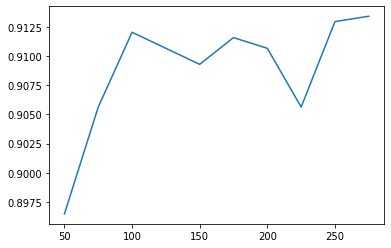

In [32]:
from matplotlib import pyplot as plt
plt.plot(l,score)
plt.show()

In [33]:
test

array([5, 0, 7, ..., 6, 9, 0], dtype=int64)